In [2]:

import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter('ignore')


## Загрузка данных

In [3]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

### Описание классов и функций

In [4]:
# функция для получения отчета о классификации
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    report = {'train_report': classification_report(y_train_true, y_train_pred),
             'test_report': classification_report(y_test_true, y_test_pred),
             'crosstab': pd.crosstab(y_test_true, y_test_pred)}
    
    return report

In [5]:
class DataPrep:
    
    def __init__(self, path_to_file):
        
        self.current_loan_amount_median = 0
        self.add_dummies_columns = None
        self.df = pd.read_csv(path_to_file)
        
    def get_loan_amount_median(self):
        
        return self.df[self.df['Current Loan Amount'] <= 9999999.0]['Current Loan Amount'].mean()
    
    def get_default_annual_income(self):
        
        annual_income = self.df[self.df['Annual Income'] != 0]['Annual Income']
        
        return (2 * annual_income.mean() + 3 * annual_income.min()) / 5
    
    def transform(self, current_loan_ammount_median, default_annual_income):
        
        df = self.df.copy()
        add_dummies_columns = None
        
        YICJ_to_numbers = {'< 1 year': '0', 
                           '1 year': '1', 
                           '2 years': '1', 
                           '3 years': '1', 
                          '4 years': '1', 
                          '5 years': '2', 
                          '6 years': '2', 
                          '7 years': '2', 
                          '8 years': '3', 
                          '9 years': '3',
                          'Years in current job_10+ years':'3'}
        
        df.loc[df['Purpose'] == 'buy a car', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'buy house', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'home improvements', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
        
        df.loc[df['Annual Income'] == 0, 'Current Loan Amount'] = default_annual_income
        
        df.loc[df['Credit Score'] >= 3000, 'Credit Score'] = (df['Credit Score'] / 10)
        
        df.loc[df['Current Loan Amount'] >= 9999999.0, 'Current Loan Amount'] = current_loan_amount_median
        
        df['TooBigLoanAmount'] = 1 * (df['Current Loan Amount'] > 9999999.0)
        
        df['Annual Income'].fillna(0.0, inplace = True)
        df['Home Ownership'].fillna('Rent', inplace = True)
        df['Years in current job'].fillna('3 years', inplace = True)
        df['Bankruptcies'].fillna(0.0, inplace = True)
        df['Months since last delinquent'].fillna(0.0, inplace = True)
        df['Credit Score'].fillna(1000.0, inplace = True)
        
        df['CreditScoreUnknown'] = 1 * (df['Credit Score'] == 0.0)
        df.loc[df['Bankruptcies'] >= 3, 'Bankruptcies'] = 3
        df['Years in current job'] = df['Years in current job'].map(YICJ_to_numbers)
        
        columns_old = set(df.columns.tolist())
        df = pd.get_dummies(df, columns = ['Home Ownership','Purpose'])
        
        columns_current = set(df.columns.tolist())
        df = pd.get_dummies(df, columns = ['Term', 'Years in current job'])
        
        columns_new = set(df.columns.tolist())
        
        for col in list(columns_new - columns_current):
            df[col] = df[col] * df['Current Loan Amount']
            df['CS' + col] = df[col] * df['Credit Score']
            
        columns_new = set(df.columns.tolist())
        self.add_dummies_columns = list(columns_new - columns_old)
        
        return df

In [6]:
#функция для балансировки df
def balance_df_by_target(df, target_name):
    
    target_counts = df[target_name].value_counts()
    
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index = True)
        
        return df.sample(frac = 1)

In [7]:
class TrainModel:
    
    def __init__(self, X, y, target_name):
        
        model = None
        classification_report = None
        X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, shuffle = True, test_size = 0.21, random_state = 79)
        df_for_balancing = pd.concat([X_train, y_train], axis = 1)
        df_balanced = balance_df_by_target(df_for_balancing, target_name)
        self.X_train = df_balanced.drop(columns = target_name)
        self.y_train = df_balanced[target_name]
        
    def log_regression(self, X):
        
        # log_regression
        
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)
    
    def knn(self, X):
        
        # K Neighbors
        
        self.model = KNeighborsClassifier()
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)
    
    def xgb(self, X, r_state):
        
        # XGBoost
        
        self.model = xgb.XGBClassifier(random_state = r_state)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)
    
    def lgbm(self, X, r_state):
        
        # LGBM
        
        self.model = lgbm.LGBMClassifier(random_state = r_state)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)
    
    def cat_boost(self, X, r_state, n_est, m_depth, cw):
        
        # catboost
        
        self.model = catb.CatBoostClassifier(random_state = r_state, silent = True, n_estimators = n_est, max_depth = m_depth, class_weights = cw)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)

In [8]:
numerical_features = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'TooBigLoanAmount', 'CreditScoreUnknown']

target = 'Credit Default'

## Подготовка данных

In [9]:
train_data_prep = DataPrep(TRAIN_DATASET_PATH)
current_loan_amount_median = train_data_prep.get_loan_amount_median()
default_annual_income = train_data_prep.get_default_annual_income()
train_df = train_data_prep.transform(current_loan_amount_median, default_annual_income)
train_df.columns
train_df = train_df[train_data_prep.add_dummies_columns + numerical_features + [target]]

In [10]:
train_df

,CSYears in current job_1,CSYears in current job_3,Purpose_moving,Term_Short Term,Purpose_other,Purpose_wedding,Years in current job_2,Home Ownership_Home Mortgage,Years in current job_0,Purpose_small business,...,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Credit Balance,Monthly Debt,Credit Score,TooBigLoanAmount,CreditScoreUnknown,Credit Default
0,2.314593e+08,0.000000e+00,0,309024.390347,0,0,0.000000,0,0.0,0,...,26.3,685960.0,1.0,0.0,47386.0,7914.0,749.0,0,0,0
1,0.000000e+00,0.000000e+00,0,0.000000,0,0,0.000000,0,0.0,0,...,15.3,1181730.0,0.0,0.0,394972.0,18373.0,737.0,0,0,1
2,0.000000e+00,2.292961e+08,0,309024.390347,0,0,0.000000,1,0.0,0,...,35.0,1182434.0,0.0,0.0,308389.0,13651.0,742.0,0,0,0
3,0.000000e+00,0.000000e+00,0,121396.000000,0,0,121396.000000,0,0.0,0,...,22.5,147400.0,1.0,0.0,95855.0,11338.0,694.0,0,0,0
4,0.000000e+00,9.047896e+07,0,125840.000000,0,0,0.000000,0,0.0,0,...,13.6,385836.0,1.0,0.0,93309.0,7180.0,719.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0.000000e+00,0.000000e+00,0,129360.000000,1,0,0.000000,0,129360.0,0,...,8.5,107866.0,0.0,0.0,73492.0,1900.0,697.0,0,0,0
7496,3.290396e+08,0.000000e+00,0,0.000000,0,0,0.000000,1,0.0,0,...,26.5,686312.0,0.0,43.0,456399.0,12783.0,741.0,0,0,1
7497,0.000000e+00,0.000000e+00,0,309024.390347,1,0,309024.390347,0,0.0,0,...,32.1,1778920.0,0.0,0.0,477812.0,12479.0,748.0,0,0,0
7498,6.152740e+08,0.000000e+00,0,615274.000000,0,0,0.000000,1,0.0,0,...,26.5,1141250.0,0.0,0.0,476064.0,37118.0,1000.0,0,0,0


In [11]:
test_data_prep = DataPrep(TEST_DATASET_PATH)
test_df = test_data_prep.transform(current_loan_amount_median, default_annual_income)
test_df = test_df[test_data_prep.add_dummies_columns + numerical_features]

In [12]:
test_df

,CSYears in current job_1,CSYears in current job_3,Purpose_moving,Term_Short Term,Purpose_other,Purpose_wedding,Years in current job_2,Home Ownership_Home Mortgage,Years in current job_0,Purpose_small business,...,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Credit Balance,Monthly Debt,Credit Score,TooBigLoanAmount,CreditScoreUnknown
0,162470000.0,0.0,0,162470.000000,0,0,0.0,0,0.0,0,...,9.0,12.5,220968.0,0.0,70.0,105906.0,6813.0,1000.0,0,0
1,54730302.0,0.0,0,78298.000000,0,0,0.0,0,0.0,0,...,6.0,32.7,55946.0,0.0,8.0,46037.0,2318.0,699.0,0,0
2,145329228.0,0.0,0,200178.000000,0,0,0.0,1,0.0,0,...,10.0,13.7,204600.0,0.0,0.0,146490.0,18729.0,726.0,0,0
3,0.0,0.0,0,217382.000000,0,0,0.0,1,0.0,0,...,16.0,17.0,456302.0,0.0,70.0,213199.0,27559.0,739.0,0,0
4,0.0,0.0,0,0.000000,0,0,777634.0,1,0.0,0,...,11.0,23.6,1207272.0,0.0,0.0,425391.0,42605.0,706.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,0,309024.390347,0,0,0.0,1,0.0,0,...,14.0,29.1,559152.0,1.0,68.0,162735.0,15046.0,745.0,0,0
2496,468512000.0,0.0,0,468512.000000,0,0,0.0,1,0.0,0,...,15.0,17.0,1737780.0,0.0,77.0,1439269.0,32996.0,1000.0,0,0
2497,299194720.0,0.0,0,430496.000000,0,0,0.0,1,0.0,0,...,48.0,12.8,1706430.0,0.0,0.0,676438.0,36912.0,695.0,0,0
2498,0.0,0.0,0,257774.000000,0,0,0.0,0,0.0,0,...,14.0,28.8,945780.0,0.0,0.0,391248.0,13506.0,744.0,0,0


## Тренеровка модели

In [13]:
model_train = TrainModel(train_df[train_data_prep.add_dummies_columns + numerical_features], train_df[target], target)
predictions = model_train.cat_boost(test_df, r_state = 167, n_est = 33, m_depth = 3, cw = [1, 1.07])
print('Train\n\n' + model_train.classification_report['train_report'])
print('Test\n\n' + model_train.classification_report['test_report'])
print('Confusion matrix\n')
print(model_train.classification_report['crosstab'])

Train

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      4271
           1       0.64      0.66      0.65      3308

    accuracy                           0.69      7579
   macro avg       0.68      0.68      0.68      7579
weighted avg       0.69      0.69      0.69      7579

Test

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1116
           1       0.42      0.55      0.47       459

    accuracy                           0.65      1575
   macro avg       0.60      0.62      0.60      1575
weighted avg       0.68      0.65      0.66      1575

Confusion matrix

col_0             0    1
Credit Default          
0               764  352
1               207  252


In [14]:
def show_feature_importances(feature_names, feature_importances, get_top = None):
    
    feature_importances = pd.DataFrame({'feature': feature_names,
                                       'importance': feature_importances})
    
    feature_importances = feature_importances.sort_values('importance', ascending = False)
    
    # plot the feature_importances
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

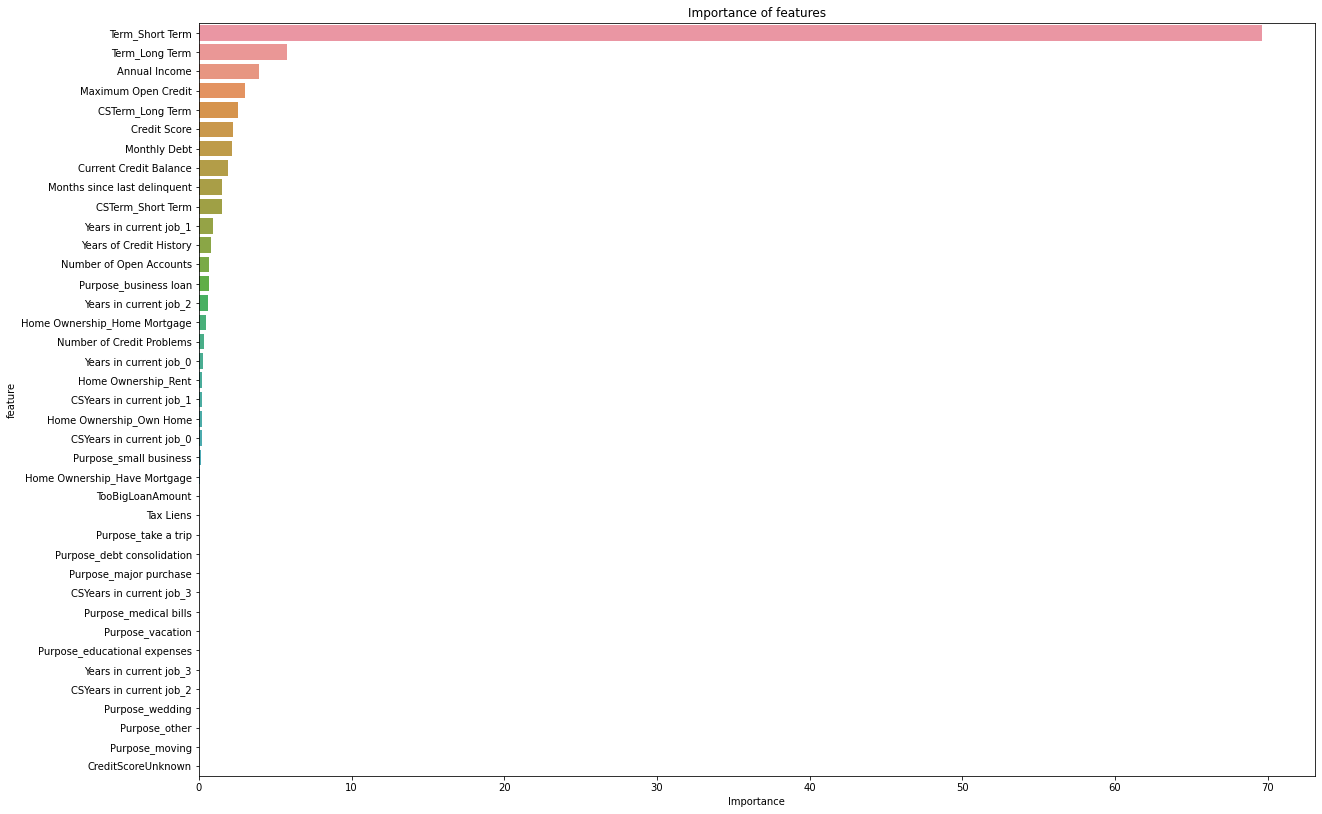

In [15]:
important_features_top = show_feature_importances(model_train.X_train.columns, model_train.model.feature_importances_, get_top = 10)

In [18]:
pd.DataFrame(predictions).to_csv("Zalutskii_Ivan_predictions.csv", index=False, encoding='utf-8')